In [1]:
import pandas as pd
import random
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from time import time

In [4]:
#Read document data
col_names=['docID', 'wordID', 'count']
df_dataText=pd.read_csv('NewYorkTimes/docword.nytimes/docword.nytimes.txt',
                header=None, delim_whitespace=True, skiprows=3,names=col_names)
#check the first 5 rows of data
df_dataText.head()

,docID,wordID,count
0,1,413,1
1,1,534,1
2,1,2340,1
3,1,2806,1
4,1,3059,1


In [5]:
print('Maximum count of words:',df_dataText['count'].max(), 
      'Minimum count of words:',df_dataText['count'].min())

Maximum count of words: 212 Minimum count of words: 1


In [6]:
#check the no. of rows and columns in dataset
df_dataText.shape

(69679427, 3)

In [7]:
#check null values
df_dataText[df_dataText['wordID'].isna()==True]['wordID'].count()

0

In [8]:
#check the number of documents
len(df_dataText['docID'].unique())

299752

In [9]:
#check the number of unique words 
len(df_dataText['wordID'].unique())

101636

In [10]:
#Find if the wordID starts with 0 or 1 and max wordID
print('wordID starts with: ',df_dataText['wordID'].min())
print('wordID ends with: ',df_dataText['wordID'].max())

wordID starts with:  1
wordID ends with:  102660


In [11]:
#Read vocabulary data
col_Vnames=['vocab_word']
df_dataVocab=pd.read_csv('NewYorkTimes/vocab.nytimes.txt',
                        header=None, delim_whitespace=True,names=col_Vnames)
df_dataVocab.head()

,vocab_word
0,aah
1,aahed
2,aaron
3,aback
4,abacus


In [12]:
#check null values
df_dataVocab[df_dataVocab['vocab_word'].isna()==True].count()

vocab_word    0
dtype: int64

In [13]:
#check the no. of rows and columns in dataset
df_dataVocab.shape

(102660, 1)

In [14]:
#check the number of unique words 
len(df_dataVocab['vocab_word'].unique())

102659

In [15]:
#Add n(id number) column to vocab data
df_dataVocab['n']=df_dataVocab.index+1
df_dataVocab.head()

,vocab_word,n
0,aah,1
1,aahed,2
2,aaron,3
3,aback,4
4,abacus,5


In [16]:
#function to collect words for each document
def get_docWords(docId):
    c1=df_dataText['docID']==docId
    c2=df_dataText['count']>=3#count greater than 3
    df_filtered=df_dataText[(c1)&(c2)][['wordID','count']].reset_index(drop=True)
    df_filtered=df_filtered.merge(df_dataVocab,left_on=['wordID'],
                                  right_on=['n'],how='inner')[['vocab_word','count']]    
    return df_filtered

In [17]:
#Lemmatize each word
def lemmatize_words(lst_tag_words):    
    lst_words_lemmatized=[]
    for w,t in lst_tag_words:
        tg=t[0].lower()
        if tg not in ['a', 'r', 'n', 'v']:
            lst_words_lemmatized.append(w)
        else:
            lst_words_lemmatized.append(obj_lemmatizer.lemmatize(w,tg))
    return lst_words_lemmatized

In [18]:
#Create cleaned text dataset in order to feed into clustering algorithms
obj_lemmatizer=WordNetLemmatizer()
train_corpus=[]
for docId in range(1,5001):
    isSuccess=True
    #get words in a document
    df_doc_words=get_docWords(docId)
    try:
        #Assign POS tag for each word, Lemmatizer requires correct POS tag to accurately lemmatize words
        df_doc_words['pos_tag']= pos_tag(df_doc_words['vocab_word'])
        #Group different inflections of the same word.
        df_doc_words['lemmatized_words']=lemmatize_words(df_doc_words['pos_tag'].tolist())
    except:
        isSuccess=False
    if isSuccess:
        txt_sentnc=''
        for i,row in df_doc_words.iterrows():
            if row['lemmatized_words']!='':
                w=row['lemmatized_words']
                if w[:4]!='zzz_':
                    txt_sentnc+=' '+(w+' ')*row['count']    
        txt_sentnc=txt_sentnc.strip()
        if txt_sentnc!='':
            txt_sentnc=txt_sentnc.split()
            random.shuffle(txt_sentnc)
            txt_sentnc=' '.join(txt_sentnc)
            train_corpus.append(txt_sentnc)

In [19]:
#Print first five sentences
train_corpus[0:5]

['scored scored play player game win play win point team play game half night game scored team player rank point point scored night rank night team half half scored game rank play team play point half rank player team win play',
 'issue paper paper front error issue number number number issue issue issue issue number paper error number issue error front number paper issue front number',
 'light midnight celebration midnight leave leave firework celebration crowd celebration security firework light friend friend friend crowd celebration security crowd terrorism crowd crowd terrorism security light midnight firework leave terrorism',
 'passenger thousand aviation air midnight passenger traffic system commercial cancel commercial flight air system flight commercial system aviation passenger commercial traffic air air midnight control control flight midnight cancel flight traffic flight cancel traffic air thousand control midnight thousand air aviation traffic passenger air air',
 'show pr

In [20]:
#print no. of elements in train_corpus
len(train_corpus)

4915

In [21]:
#########################   Vectorization  #########################

In [22]:
#Create vector of words for each document using TfidfVectorizer
time_start=time()
obj_vectorizer=TfidfVectorizer()
train_corpus_vectorized = obj_vectorizer.fit_transform(train_corpus)
time_taken=time()-time_start
print('Time(seconds) taken to vectorize text data:',time_taken)
train_corpus_vectorized

Time(seconds) taken to vectorize text data: 1.0237939357757568


<4915x5807 sparse matrix of type '<class 'numpy.float64'>'
	with 64115 stored elements in Compressed Sparse Row format>

In [ ]:
######################### Clustering k-means  #########################

In [ ]:
'''
News categories from NewYork times
----------------------------------
Education, Weather, Politics, Business, Technology, 
Science, Health, Arts, Sports, Automobiles, 
Books, Movies, Dining & Wine, Home & Garden, Fashion & Style, 
Travel
'''

In [34]:
#Find optimal k
lst_sum_sqrdDstnc = []
lst_k = range(1,50)
for k in lst_k:
    obj_kmeansModel = KMeans(n_clusters=k, init='k-means++')
    obj_kmeansModel = obj_kmeansModel.fit(train_corpus_vectorized)
    lst_sum_sqrdDstnc.append(obj_kmeansModel.inertia_)
print('Sum of squared distances: ',lst_sum_sqrdDstnc)

Sum of squared distances:  [4858.022112308217, 4783.700603017065, 4743.844907043461, 4707.964672423966, 4675.293187861651, 4630.132621396857, 4610.6225275703755, 4584.061781476942, 4565.843602893804, 4550.96159179005, 4525.533705755692, 4497.140951927156, 4482.852057613711, 4464.830335647557, 4449.67878814535, 4437.041548241703, 4426.433356856204, 4408.248763793084, 4377.915354819804, 4374.156981634963, 4354.423578674616, 4353.5948723112815, 4344.3695229363675, 4330.126413107971, 4318.244391445674, 4312.186024251035, 4294.3528720738, 4294.297583782735, 4280.532056516204, 4269.855831415304, 4266.005124715298, 4252.663088120542, 4242.55606881093, 4240.708422877047, 4231.046028191113, 4211.78479729948, 4207.052422954881, 4200.25754350748, 4193.490861539541, 4192.3125926276625, 4180.430683327662, 4167.720778481529, 4171.393817502214, 4165.762117794812, 4146.956956392174, 4143.458346303323, 4130.870506733675, 4131.513367686824, 4123.858891901067]


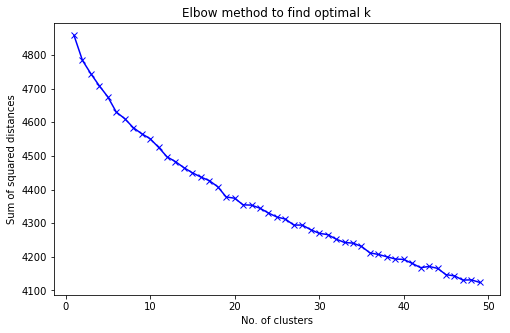

In [35]:
#Plot to find optimal k
plt.plot(lst_k, lst_sum_sqrdDstnc, 'bx-')
plt.rcParams["figure.figsize"] = (8, 5)
plt.xlabel('No. of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method to find optimal k')
plt.show()

In [36]:
#KMeans clustering model
time_start=time()
optimalK=18
obj_kmeansModel = KMeans(n_clusters=optimalK, init='k-means++')
obj_kmeansModel.fit(train_corpus_vectorized)
time_taken=time()-time_start
print('Time(seconds) taken to train KMeans model:',time_taken)

Time(seconds) taken to train KMeans model: 18.1162371635437


In [37]:
pred_labels=obj_kmeansModel.labels_
pred_labels

array([10,  4,  4, ...,  4,  4,  4])

In [38]:
df_result=pd.DataFrame({"text":train_corpus,"labels":pred_labels})
df_result.head(10)

,text,labels
0,scored scored play player game win play win po...,10
1,issue paper paper front error issue number num...,4
2,light midnight celebration midnight leave leav...,4
3,passenger thousand aviation air midnight passe...,4
4,show program program television show televisio...,8
5,red village village computer government red re...,15
6,celebrate million million problem firework com...,4
7,thousand midnight western western calendar rel...,4
8,night music show firework midnight millennium ...,4
9,parade night millennium family millennium mill...,4


In [ ]:
######################### Evaluate Results #########################

In [39]:
dbi_score = metrics.davies_bouldin_score(train_corpus_vectorized.toarray(), pred_labels)
print("Davies Bouldin Score:", dbi_score)
silhouet_score = metrics.silhouette_score(train_corpus_vectorized.toarray(), pred_labels , 
                                          metric='euclidean')
print("Silhoutte Score:", silhouet_score)

Davies Bouldin Score: 4.5031274856130254
Silhoutte Score: 0.03075543284802214


In [40]:
#Plot wordcloud
def plot_wordcloud(text):
    wordCloud = WordCloud(width = 800, height = 500, min_font_size = 14,
                          background_color ='white').generate(text) 
    plt.figure(figsize = (8, 6))    
    plt.imshow(wordCloud) 
    plt.axis("off")  
    plt.show()

10
-  -  -  -  -  -  -  -  -  -  -  -


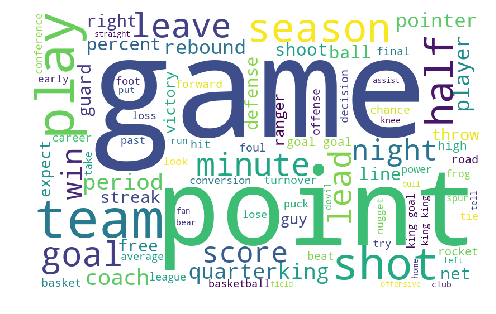

4
-  -  -  -  -  -  -  -  -  -  -  -


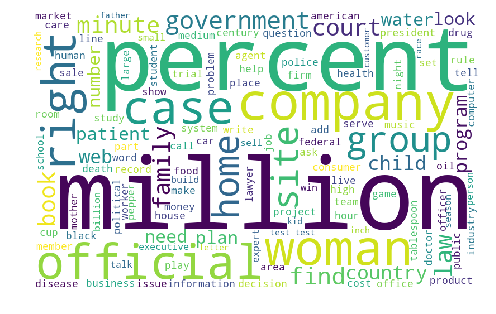

8
-  -  -  -  -  -  -  -  -  -  -  -


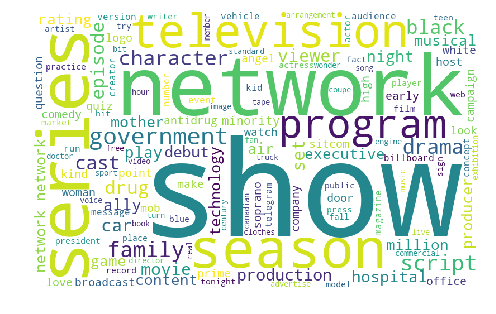

15
-  -  -  -  -  -  -  -  -  -  -  -


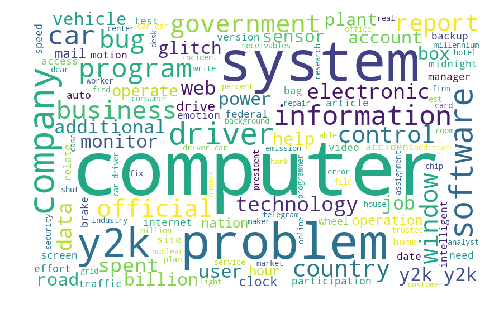

3
-  -  -  -  -  -  -  -  -  -  -  -


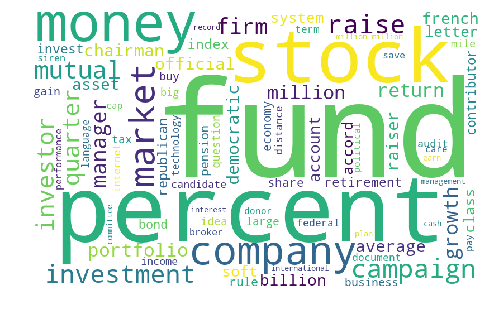

5
-  -  -  -  -  -  -  -  -  -  -  -


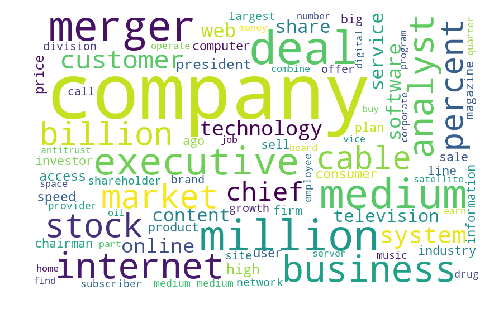

13
-  -  -  -  -  -  -  -  -  -  -  -


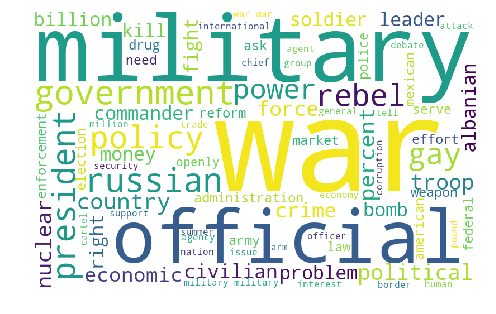

6
-  -  -  -  -  -  -  -  -  -  -  -


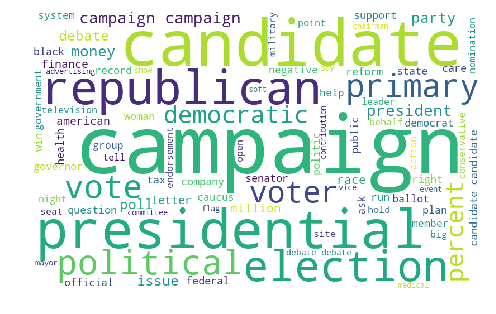

7
-  -  -  -  -  -  -  -  -  -  -  -


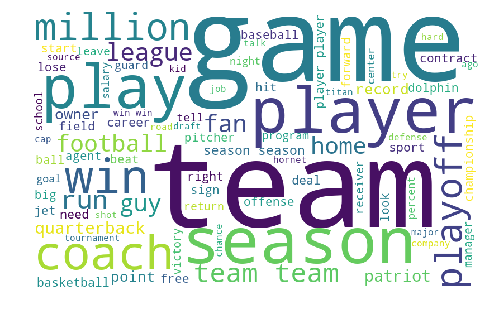

14
-  -  -  -  -  -  -  -  -  -  -  -


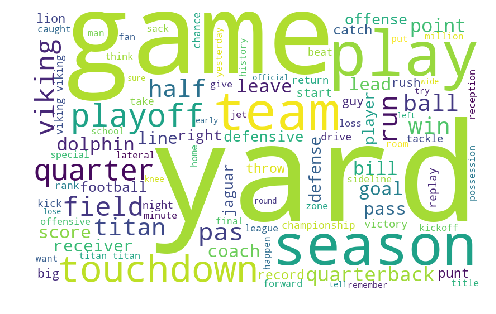

16
-  -  -  -  -  -  -  -  -  -  -  -


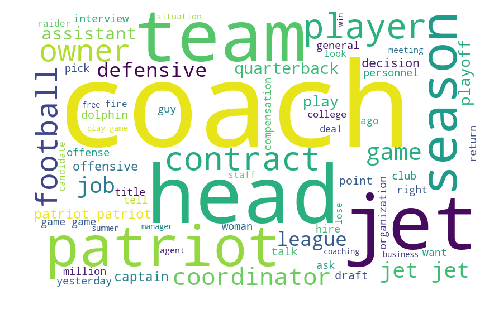

9
-  -  -  -  -  -  -  -  -  -  -  -


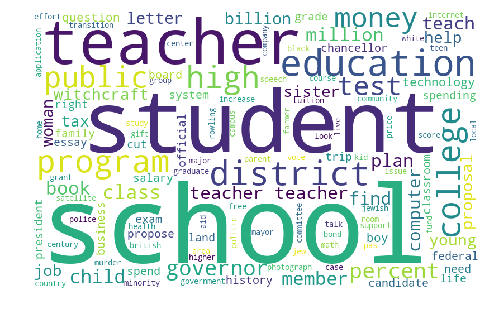

1
-  -  -  -  -  -  -  -  -  -  -  -


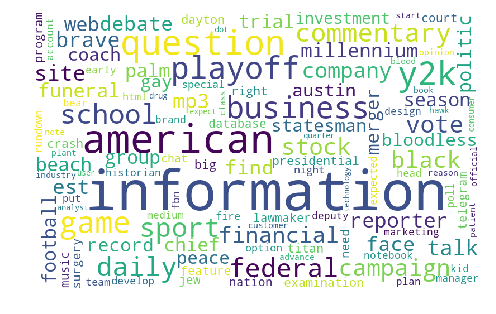

0
-  -  -  -  -  -  -  -  -  -  -  -


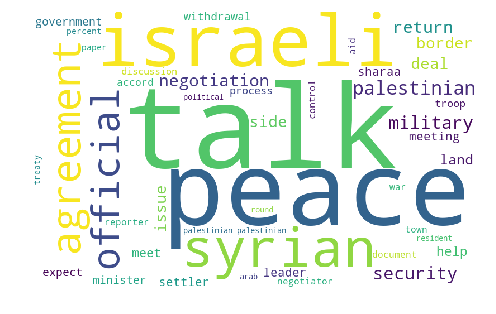

17
-  -  -  -  -  -  -  -  -  -  -  -


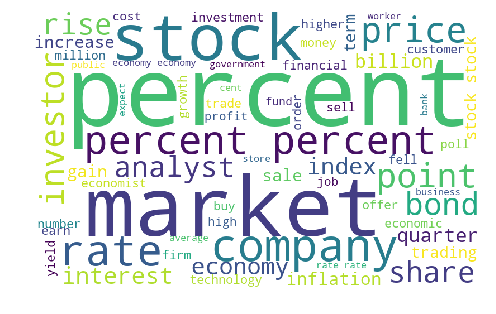

12
-  -  -  -  -  -  -  -  -  -  -  -


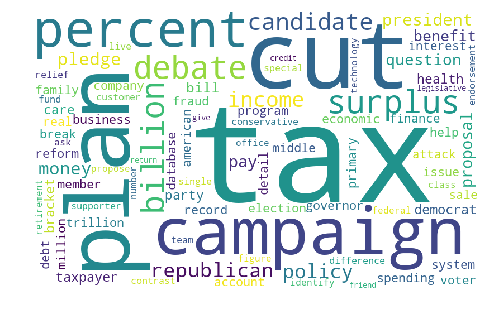

2
-  -  -  -  -  -  -  -  -  -  -  -


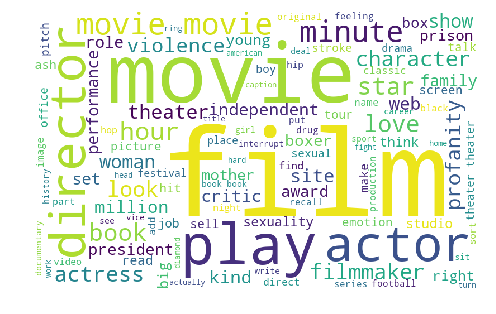

11
-  -  -  -  -  -  -  -  -  -  -  -


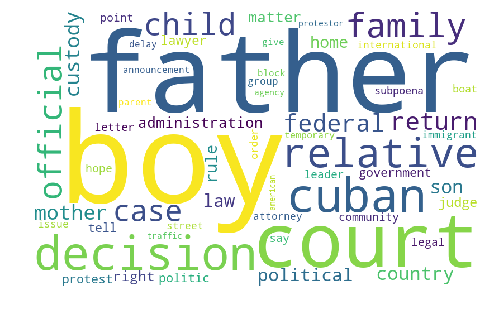

In [41]:
#Plot wordcloud
for i in df_result.labels.unique():
    df_plt=df_result[df_result.labels==i]
    text=" ".join(df_plt.text.tolist())
    print(i)
    print('-  -  -  -  -  -  -  -  -  -  -  -')
    plot_wordcloud(text)
